In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Convolution2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Will use only the first GPU device

In [3]:
tf.__version__

'2.1.0'

In [4]:
keras.__version__

'2.2.4-tf'

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.shape

(42000, 785)

In [7]:
test.shape

(28000, 784)

In [8]:
y_train = train['label']
x_train = train.drop(labels=['label'], axis=1)
x_train = x_train / 255.0
x_test = test / 255.0
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train, num_classes = 10)

In [9]:
x_train.shape

(42000, 28, 28, 1)

In [10]:
x_test.shape

(28000, 28, 28, 1)

c:\users\wonhee\anaconda3\envs\tensorgpu211\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


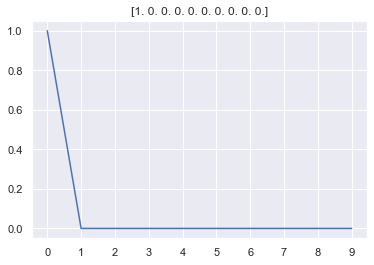

In [11]:
plt.title(y_train[200])
plt.plot(y_train[200])
plt.xticks(range(10));
plt.show()

In [12]:
X = x_train
y = y_train
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train, y_train, test_size=0.10, random_state = 42)

In [13]:
with tf.device("/device:GPU:0"):
    def cnn_model():
        model = Sequential([
            Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            BatchNormalization(),
            Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'),
            BatchNormalization(),
            Convolution2D(filters=32, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Dropout(0.4),
            
            Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'),
            BatchNormalization(),
            Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'),
            BatchNormalization(),
            Convolution2D(filters=64, kernel_size=(5, 5), strides=2, padding='same', activation='relu'),
            BatchNormalization(),
            Dropout(0.4),
            
            Convolution2D(filters=128, kernel_size=(4, 4), padding='same', activation='relu'),
            BatchNormalization(),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.4),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

        return model
    

In [14]:
cnn_model = cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)       

In [ ]:
def exponential_decay(epochs):
    def exponential_decay_fn(lr, s):
        return lr * 0.95**(epochs/20)
    return exponential_decay_fn

In [17]:
epochs=50
learning_rate_reduction = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
learning_rate_reduction2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
checkpoint_cb = ModelCheckpoint('best_model_checkpoint.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, shear_range=0.3, height_shift_range=0.1, zoom_range=0.1)
batch_size = 128
batches = gen.flow(X_train2, y_train2, batch_size=batch_size)
history=cnn_model.fit_generator(generator=batches, steps_per_epoch=X_train2.shape[0]//batch_size, validation_data = (X_val2, y_val2), epochs=epochs, callbacks=[checkpoint_cb, early_stopping, learning_rate_reduction2])

Epoch 1/50
295/295 [==============================] - 10s 33ms/step - loss: 0.5241 - accuracy: 0.8358 - val_loss: 7.6981 - val_accuracy: 0.1171
Epoch 2/50
295/295 [==============================] - 7s 25ms/step - loss: 0.1370 - accuracy: 0.9595 - val_loss: 0.1538 - val_accuracy: 0.9574
Epoch 3/50
295/295 [==============================] - 7s 25ms/step - loss: 0.1085 - accuracy: 0.9687 - val_loss: 0.0322 - val_accuracy: 0.9900
Epoch 4/50
295/295 [==============================] - 8s 26ms/step - loss: 0.0929 - accuracy: 0.9726 - val_loss: 0.0605 - val_accuracy: 0.9833
Epoch 5/50
295/295 [==============================] - 8s 26ms/step - loss: 0.0811 - accuracy: 0.9773 - val_loss: 0.0627 - val_accuracy: 0.9819A: 0s - loss: 0.0
Epoch 6/50
295/295 [==============================] - 8s 26ms/step - loss: 0.0740 - accuracy: 0.9786 - val_loss: 0.0327 - val_accuracy: 0.9886
Epoch 7/50
295/295 [==============================] - 8s 25ms/step - loss: 0.0531 - accuracy: 0.9845 - val_loss: 0.0199 - va

In [ ]:
cnn_model.save('CNN 2x2 2x2 1x1 epoch30 batch86 lr.h5')

In [ ]:
cnn_history = history.history
pd.DataFrame(cnn_history).plot(figsize=(10, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
cnn_history.keys()

In [ ]:
losses = cnn_history['loss']
val_losses = cnn_history['val_loss']
epochs = range(1, len(val_losses)+1)

plt.plot(epochs, losses, 'bo')
plt.plot(epochs, val_losses, 'b+')
plt.xlabel('Epoches')
plt.ylabel('Losses')

In [ ]:
lr = cnn_history['lr']

plt.plot(epochs, lr)
plt.xlabel('Epochs')
plt.ylabel('Learning rate')

In [ ]:
accuracy = cnn_history['accuracy']
val_accuracy = cnn_history['val_accuracy']
epochs = range(1, len(val_losses)+1)

plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, val_accuracy, 'b+')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')

In [ ]:
finalmodels = cnn_model.predict(x_test)
results = np.argmax(finalmodels, axis=1)
results = pd.Series(results, name='label')

In [ ]:
submissions = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submissions.to_csv("submissionCNN2222118630.csv", index=False, header=True)